In [2]:
from mikeio import Dfsu

%load_ext autoreload
%autoreload 2

filename = "../tests/testdata/HD2D.dfsu"
dfs = Dfsu(filename)

#ds = dfs.read(["Surface elevation","Current speed"]) # to read some variables
ds = dfs.read()

ds

<mikeio.DataSet>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

In [3]:
ds.items

[Surface elevation <Surface Elevation> (meter),
 U velocity <u velocity component> (meter per sec),
 V velocity <v velocity component> (meter per sec),
 Current speed <Current Speed> (meter per sec)]

Find which element is closest to POI.

In [4]:
idx = dfs.find_closest_element_index(606200, 6905480)

Extract a subset of the dataset from this element. (Discrete values, no interpolation)

In [5]:
selds = ds.isel(idx=idx)
selds

<mikeio.DataSet>
Dimensions: (9,)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

Convert to a dataframe, for convenience.

In [6]:
df = selds.to_dataframe()
df.head()

,Surface elevation,U velocity,V velocity,Current speed
1985-08-06 07:00:00,0.459460,0.006372,-0.007143,0.009572
1985-08-06 09:30:00,0.806965,0.010517,0.003438,0.011064
1985-08-06 12:00:00,0.100285,0.011300,0.012926,0.017169
1985-08-06 14:30:00,-0.727009,0.010402,0.010033,0.014452
1985-08-06 17:00:00,-0.579541,0.007293,-0.000902,0.007349


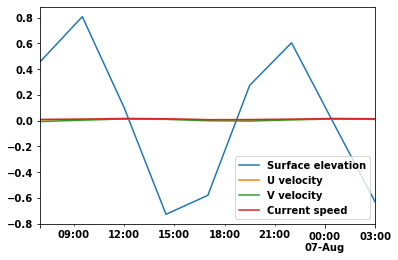

In [7]:
df.plot()

## Other ways to subset data 

Assume that we interested in these 3 points only

In [8]:
pt1 = (606200, 6905480)
pt2 = (606300, 6905410)
pt3 = (606400, 6905520)
pts_x = [pt1[0], pt2[0], pt3[0]]
pts_y = [pt1[1], pt2[1], pt3[1]]
elem_ids = dfs.find_closest_element_index(pts_x, pts_y)

We can use these element ids either when we select the data from the complete dataset using the method isel() as shown above or already when we read the data from file (particular useful for files larger than memory)

In [9]:
ds_pts = dfs.read(element_ids=elem_ids)
ds_pts

<mikeio.DataSet>
Dimensions: (9, 3)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

### Select area
Let's take the area North of y=6905480

In [10]:
yc = dfs.element_coordinates[:,1]

In [11]:
elem_ids = dfs.element_ids[yc>6905480] 

And find the maximum average current speed in this area in the last time step

In [12]:
item_num = 3
print(ds.items[item_num])
subset = ds.data[3][:,elem_ids] 
subset_timeavg = subset.mean(axis=0) 
idx = subset_timeavg.argmax()
coords = dfs.element_coordinates[idx,0:2].round(1)
print(f'Max current speed in area is found in {coords} and is {subset_timeavg[idx]:.3f}m/s')

Current speed <Current Speed> (meter per sec)
Max current speed in area is found in [ 605969.5 6905396. ] and is 0.078m/s


Let us save the time averaged subset to a dfsu file. 

In [13]:
outfilename = "HD2D_north.dfsu"
data = []
data.append(subset_timeavg.reshape(1,-1))
items = ds.items[item_num]
dfs.write(outfilename, data, items=[items], element_ids=elem_ids)

# Create a new dfsu file

* Subset of items
* Subset of timesteps
* Renamed variables

First inspect the source file:

In [14]:
ds

<mikeio.DataSet>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

In [16]:
from mikeio.eum import ItemInfo, EUMType
from mikeio.dutil import Dataset

sourcefilename = filename
outfilename = "HD2D_selected.dfsu"

starttimestep = 4
time = ds.time[starttimestep:]

data = []
data.append(ds['U velocity'][starttimestep:,:])
data.append(ds['V velocity'][starttimestep:,:])

items = [ItemInfo("eastward_sea_water_velocity", EUMType.u_velocity_component),
         ItemInfo("northward_sea_water_velocity",EUMType.v_velocity_component)]

newds = Dataset(data,time,items)

dfs.write(outfilename, newds) # Note, this method was previosly named create

Read the newly created file to verify the contents.

In [17]:
newdfs = Dfsu(outfilename)

newds2 = newdfs.read()
newds2

<mikeio.DataSet>
Dimensions: (5, 884)
Time: 1985-08-06 17:00:00 - 1985-08-07 03:00:00
Items:
  0:  eastward_sea_water_velocity <u velocity component> (meter per sec)
  1:  northward_sea_water_velocity <v velocity component> (meter per sec)

In [18]:
newds.items

[eastward_sea_water_velocity <u velocity component> (meter per sec),
 northward_sea_water_velocity <v velocity component> (meter per sec)]

# Write mesh from dfsu file
Don't you have the original mesh? No problem - you can re-create it from the dfsu file... 

In [23]:
outmesh = 'mesh_from_HD2D.mesh'
dfs.to_mesh(outmesh)

# Clean up

In [21]:
import os
os.remove(outfilename)
os.remove(outmesh)

In [28]:
dfs= Dfsu('../tests/testdata/basin_3d.dfsu')
dfs.n_z_layers

0

In [37]:
elem_ids = dfs.get_layer_n_element_ids(-2)

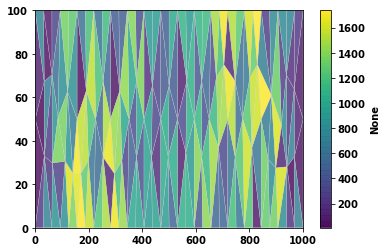

In [38]:
dfs.plot(elem_ids)